In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [3]:
# Load waypoints
file_name = "IL_C_F_RCCW_1"
# output_dir = f"/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Straight Line/Diagonal Line/{file_name}"
output_dir = f"/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Infinity Loop/{file_name}"
data_path = os.path.join(output_dir, "pose_waypoints_sampled_2.5hz_clean.csv")
data_path_2 = os.path.join(output_dir, "pose_waypoints_sampled_2.5hz_clean.csv")
plot_2 = False
speed_avg = False

# data_path = os.path.join(output_dir, "pose_waypoints_full.csv")

In [186]:
# Parse ground truth data
ground_truth = []
ground_truth_2 = []

# Read the CSV file with a header
with open(data_path, "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        ground_truth.append([float(row["timestamp"]), float(row["ped_id"]), float(row["x"]), float(row["y"])])

# Read the CSV file with a header
with open(data_path_2, "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        ground_truth_2.append([float(row["timestamp"]), float(row["ped_id"]), float(row["x"]), float(row["y"])])
        
gt_array = np.array(ground_truth)
gt_array_2 = np.array(ground_truth_2)

In [187]:
len(gt_array)

29

In [188]:
## Prediction function, for later
pred_model = 'CV'

# Make an empty dataframe to store the error values in next steps
results_df = pd.DataFrame()

# # Read the saved CSV file back into a DataFrame
# results_df = pd.read_csv("results_df.csv")

# Display the loaded DataFrame
results_df

""


In [189]:
## Prediction

# Group data by pedestrian ID (column 1)
pedestrian_ids = np.unique(gt_array[:, 1])
predictions = {}

ph = 1

for ped_id in pedestrian_ids:
    # Filter data for the current pedestrian
    ped_data = gt_array[gt_array[:, 1] == ped_id]
    
    # Initialize predictions for this pedestrian
    ped_predictions = []
    
    for i in range(0, len(ped_data) - 1 - ph):
        # Extract current and next timestep data
        t1, x1, y1 = ped_data[i, 0], ped_data[i, 2], ped_data[i, 3]
        t2, x2, y2 = ped_data[i + 1, 0], ped_data[i + 1, 2], ped_data[i + 1, 3]

        # Calculate velocity (vx, vy)
        vx = (x2 - x1) / (t2 - t1)
        vy = (y2 - y1) / (t2 - t1)
        
        if speed_avg and i > 0:
            t0, x0, y0 = ped_data[i-1, 0], ped_data[i-1, 2], ped_data[i-1, 3]
            vx_p = (x1 - x0) / (t1 - t0)
            vy_p = (y1 - y0) / (t1 - t0)

            vx = (vx + vx_p) / 2
            vy = (vy + vy_p) / 2

        ### PREDICTION PART ###
        
        # Predict next position assuming constant velocity
        t_next = t2 + ph * (t2 - t1)  # Assuming uniform timestep
        x_next = x2 + vx * ph * (t2 - t1)
        y_next = y2 + vy * ph * (t2 - t1)
        
        # Store the prediction
        ped_predictions.append([t_next, ped_id, x_next, y_next])

    # Store predictions for this pedestrian
    predictions[ped_id] = ped_predictions

p_x = []
p_y = []
# Print predictions for each pedestrian
for ped_id, pred in predictions.items():
    # print(f"Predictions for pedestrian {ped_id}:")
    for p in pred:
        # print(p)
        p_x.append(p[2])
        p_y.append(p[3])

len(p_x)

27

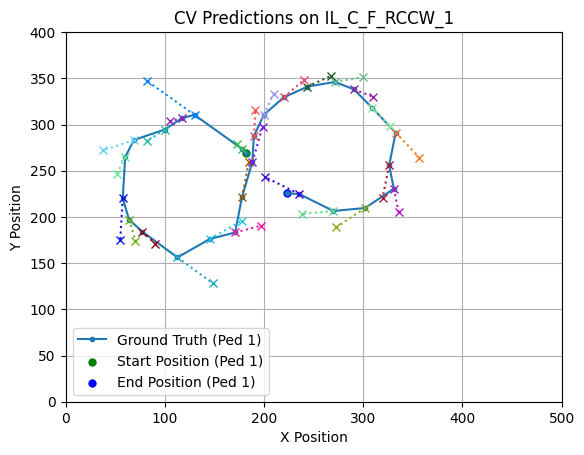

In [190]:
# # Assuming `data_array` and `predictions` are already computed as in the previous code

# # Extract x and y limits for the plot
# x_min, x_max = np.min(data_array[:, 2]), np.max(data_array[:, 2])
# y_min, y_max = np.min(data_array[:, 3]), np.max(data_array[:, 3])

# # Create the combined plot
# plt.figure(figsize=((x_max - x_min) * 0.5, (y_max - y_min) * 0.5), dpi=300)

# Set the x and y axis limits
plt.xlim(0, 500)
plt.ylim(0, 400)

pedestrian_ids = np.unique(gt_array[:, 1])

# Plot ground truth trajectory (blue)
for ped_id in pedestrian_ids:
    # Filter ground truth data for the pedestrian
    ped_data = gt_array[gt_array[:, 1] == ped_id]
    ped_data_2 = gt_array_2[gt_array_2[:, 1] == ped_id]

    x_gt, y_gt = ped_data[:, 2], ped_data[:, 3]
    x_gt_2, y_gt_2 = ped_data_2[:, 2], ped_data_2[:, 3]
    
    # Plot ground truth trajectory
    plt.plot(x_gt, y_gt, marker="o", linestyle="-", markersize=3,
             label=f"Ground Truth (Ped {int(ped_id)})", linewidth=1.5)
    
    if plot_2:
        plt.plot(x_gt_2, y_gt_2, marker="*", linestyle="-", markersize=3,
            label=f"Ground Truth (Ped {int(ped_id)})", linewidth=1.5)

    ## Plot predicted trajectory

    # Connect ground truth to prediction

    if ped_id in predictions:
        j = 1
        for pred in predictions[ped_id]:
            t_pred, ped_id_pred, x_pred, y_pred = pred
            # plt.text(x_pred + 5, y_pred + 5, f"({x_pred:.1f}, {y_pred:.1f})", fontsize=6, color="red")
            
            plt.plot([x_gt[j], x_pred], [y_gt[j], y_pred], color=np.random.rand(3,),
                     marker="x", linestyle='dotted')
            j += 1

            # Othe types of plots can be added here, but be careful about multiple labels. It's better for the multi-step predictions, I think


    
    # plt.plot(p_x, p_y, marker="x", linewidth=1, linestyle='--', label='Predicted Positions', color="red") # Connect all prediction to each other
    # plt.scatter(p_x, p_y, marker="x", label='Predicted Positions', color="red") # Just show the predicted positions

# Mark start and end positions
for ped_id in np.unique(gt_array[:, 1]):
    ped_data = gt_array[gt_array[:, 1] == ped_id]
    x_gt, y_gt = ped_data[:, 2], ped_data[:, 3]
    plt.scatter(x_gt[0], y_gt[0], color="green", s=25, label=f"Start Position (Ped {int(ped_id)})")
    plt.scatter(x_gt[-1], y_gt[-1], color="blue", s=25, label=f"End Position (Ped {int(ped_id)})")
    
# plt.gca().invert_yaxis()  # Invert Y to match video coordinates
# plt.gca().invert_xaxis()  # Invert X to match video coordinates

# Titles and labels
plt.title(f"{pred_model} Predictions on {file_name}")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
plt.close()

In [191]:
error_ade = []
error_ade_normal = []

# Calculate ADE
i = 0
for _, _, x, y in ground_truth[1+ph:]:
        pred = np.array((p_x[i], p_y[i]))
        gt = np.array((x, y))

        dist = np.linalg.norm(pred - gt, axis=-1)
        error_ade.append(dist)

        # print('*********', pred, gt, dist)

        # In case of multe-step ahead prediction, all intermediate step sizes all considered. Another option is just to consider the direct distance to from origin gt to the prediction's corresponding gt, which is not considered here.

        steps_size = 0
        for j in range(1, ph + 1):
            step_start = np.array((ground_truth[i + j][2], ground_truth[i + j][3]))
            step_end = np.array((ground_truth[i + j + 1][2], ground_truth[i + j + 1][3]))

            steps_size += np.linalg.norm(step_end - step_start, axis=-1)

        # step_start = np.array((ground_truth[i + 1][2], ground_truth[i + 1][3]))
        # step_end = np.array((ground_truth[i + 2][2], ground_truth[i + 2][3]))
        # step_size = np.linalg.norm(step_end - step_start, axis=-1)

        error_ade_normal.append(dist / steps_size)
        
        i += 1

ade_avg = np.average(error_ade)
print('Average prediction error: {:.2f}'.format(ade_avg))

ade_avg_normal = np.average(error_ade_normal)
print('Average prediction error normalized: {:.2f}'.format(ade_avg_normal))

Average prediction error: 21.49
Average prediction error normalized: 0.80


In [ ]:
# # Define file names and data paths
# file_names = ["DL_C_F_BRTL_1", "DL_C_F_BRTL_2", "DL_C_F_BRTL_3", "DL_C_F_BRTL_4", "DL_C_F_BRTL_5", "DL_C_F_BRTL_6"]
# data_files = ["pose_waypoints_sampled_10hz_clean.csv", "pose_waypoints_sampled_2.5hz_clean.csv", "pose_waypoints_full_clean.csv"]

# Directory for datasets
base_dir = "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Straight Line/Horizontal Line"
# base_dir = "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Circular Path"

# Placeholder for results
results = []

# Loop through file names and data files
for root, dirs, files in os.walk(base_dir):

    dataset_name = root.split("/")[-1]
    if dataset_name.startswith('x_'):
        continue

    for file in files:

        if file.endswith("_raw.csv") or file.endswith("_2.5hz_clean.csv"): ## REMEMBER TO EXCLUSE THE 2.5hz DATASET FOR HIGHER PH
            continue
        
        data_path = os.path.join(root, file)

        # Load data and calculate prediction error
        try:
            # Parse ground truth data
            ground_truth = []

            # Read the CSV file with a header
            with open(data_path, "r") as csvfile:
                reader = csv.DictReader(csvfile)
                for row in reader:
                    ground_truth.append([float(row["timestamp"]), float(row["ped_id"]), float(row["x"]), float(row["y"])])
                    
            gt_array = np.array(ground_truth)

            # Group data by pedestrian ID (column 1)
            pedestrian_ids = np.unique(gt_array[:, 1])
            predictions = {}

            for ped_id in pedestrian_ids:
                # Filter data for the current pedestrian
                ped_data = gt_array[gt_array[:, 1] == ped_id]
                
                # Initialize predictions for this pedestrian
                ped_predictions = []

                ph = 1
                
                for i in range(0, len(ped_data) - 1 - ph):
                    # Extract current and next timestep data
                    t1, x1, y1 = ped_data[i, 0], ped_data[i, 2], ped_data[i, 3]
                    t2, x2, y2 = ped_data[i + 1, 0], ped_data[i + 1, 2], ped_data[i + 1, 3]
                    
                    # Calculate velocity (vx, vy)
                    vx = (x2 - x1) / (t2 - t1)
                    vy = (y2 - y1) / (t2 - t1)

                    if speed_avg and i > 0:
                        t0, x0, y0 = ped_data[i-1, 0], ped_data[i-1, 2], ped_data[i-1, 3]
                        vx_p = (x1 - x0) / (t1 - t0)
                        vy_p = (y1 - y0) / (t1 - t0)

                        vx = (vx + vx_p) / 2
                        vy = (vy + vy_p) / 2

                    ### PREDICTION PART ###
                    
                    # Predict next position assuming constant velocity
                    t_next = t2 + ph * (t2 - t1)  # Assuming uniform timestep
                    x_next = x2 + vx * ph * (t2 - t1)
                    y_next = y2 + vy * ph * (t2 - t1)
                    
                    # Store the prediction
                    ped_predictions.append([t_next, ped_id, x_next, y_next])

                # Store predictions for this pedestrian
                predictions[ped_id] = ped_predictions

            p_x = []
            p_y = []
            # Print predictions for each pedestrian
            for ped_id, pred in predictions.items():
                # print(f"Predictions for pedestrian {ped_id}:")
                for p in pred:
                    # print(p)
                    p_x.append(p[2])
                    p_y.append(p[3])

            
            error_ade = []
            error_ade_normal = []

            # Calculate ADE
            i = 0
            for _, _, x, y in ground_truth[1+ph:]:
                    pred = np.array((p_x[i], p_y[i]))
                    gt = np.array((x, y))

                    dist = np.linalg.norm(pred - gt, axis=-1)
                    
                    error_ade.append(dist)


                    # In case of multe-step ahead prediction, all intermediate step sizes all considered. Another option is just to consider the direct distance to from origin gt to the prediction's corresponding gt, which is not considered here.
        
                    steps_size = 0
                    for j in range(1, ph + 1):
                        step_start = np.array((ground_truth[i + j][2], ground_truth[i + j][3]))
                        step_end = np.array((ground_truth[i + j + 1][2], ground_truth[i + j + 1][3]))

                        steps_size += np.linalg.norm(step_end - step_start, axis=-1)

                        # step_start = np.array((ground_truth[i + 1][2], ground_truth[i + 1][3]))
                        # step_end = np.array((ground_truth[i + 2][2], ground_truth[i + 2][3]))
                        # step_size = np.linalg.norm(step_end - step_start, axis=-1)

                    error_ade_normal.append(dist / steps_size)

                    i += 1

            
            ade_avg = np.average(error_ade)
            # print('Average prediction error: {:.2f}'.format(ade_avg))

            ade_avg_normal = np.average(error_ade_normal)
            # print('Average prediction error normalized: {:.2f}'.format(ade_avg_normal))

            
            # Append result
            results.append({
                "dataset_name": dataset_name,
                "path_type": dataset_name[:4],
                "acceleration_type": dataset_name.split("_")[2],
                "path_direction": dataset_name.split("_")[3],
                "path_number": dataset_name.split("_")[4],
                "sample_rate": file.split("_")[-2],
                "ph": ph,
                "prediction_model": pred_model,
                "speed_avg": speed_avg,
                "average_error": ade_avg,
                "average_error_normal": ade_avg_normal
            })

            # print(f"Processed {file_name} with {data_file}: Average Error = {ade_avg}")
        except Exception as e:
            print(f"Error processing {dataset_name} with {file}: {e}")

# Display results
for result in results:
    print(result)

In [28]:
speed_avg = True

# Directories for datasets
base_dirs = [
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Straight Line/Vertical Line",
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Straight Line/Horizontal Line",
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Straight Line/Diagonal Line",
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Infinity Loop",
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Square Path",
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Circular Path"
]

# Placeholder for results
results = []

for base_dir in base_dirs:
    # Loop through file names and data files
    for root, dirs, files in os.walk(base_dir):

        dataset_name = root.split("/")[-1]
        if dataset_name.startswith('x_'):
            continue

        for file in files:

            if file.endswith("_raw.csv") or file.endswith("_2.5hz_clean.csv"): ## REMEMBER TO EXCLUSE THE 2.5hz DATASET FOR HIGHER PH
                continue
            
            data_path = os.path.join(root, file)

            # Load data and calculate prediction error
            try:
                # Parse ground truth data
                ground_truth = []

                # Read the CSV file with a header
                with open(data_path, "r") as csvfile:
                    reader = csv.DictReader(csvfile)
                    for row in reader:
                        ground_truth.append([float(row["timestamp"]), float(row["ped_id"]), float(row["x"]), float(row["y"])])
                        
                gt_array = np.array(ground_truth)

                # Group data by pedestrian ID (column 1)
                pedestrian_ids = np.unique(gt_array[:, 1])
                predictions = {}

                for ped_id in pedestrian_ids:
                    # Filter data for the current pedestrian
                    ped_data = gt_array[gt_array[:, 1] == ped_id]
                    
                    # Initialize predictions for this pedestrian
                    ped_predictions = []

                    ph = 4
                    
                    for i in range(0, len(ped_data) - 1 - ph):
                        # Extract current and next timestep data
                        t1, x1, y1 = ped_data[i, 0], ped_data[i, 2], ped_data[i, 3]
                        t2, x2, y2 = ped_data[i + 1, 0], ped_data[i + 1, 2], ped_data[i + 1, 3]
                        
                        # Calculate velocity (vx, vy)
                        vx = (x2 - x1) / (t2 - t1)
                        vy = (y2 - y1) / (t2 - t1)

                        if speed_avg and i > 0:
                            t0, x0, y0 = ped_data[i-1, 0], ped_data[i-1, 2], ped_data[i-1, 3]
                            vx_p = (x1 - x0) / (t1 - t0)
                            vy_p = (y1 - y0) / (t1 - t0)

                            vx = (vx + vx_p) / 2
                            vy = (vy + vy_p) / 2

                        ### PREDICTION PART ###
                        
                        # Predict next position assuming constant velocity
                        t_next = t2 + ph * (t2 - t1)  # Assuming uniform timestep
                        x_next = x2 + vx * ph * (t2 - t1)
                        y_next = y2 + vy * ph * (t2 - t1)
                        
                        # Store the prediction
                        ped_predictions.append([t_next, ped_id, x_next, y_next])

                    # Store predictions for this pedestrian
                    predictions[ped_id] = ped_predictions

                p_x = []
                p_y = []
                # Print predictions for each pedestrian
                for ped_id, pred in predictions.items():
                    # print(f"Predictions for pedestrian {ped_id}:")
                    for p in pred:
                        # print(p)
                        p_x.append(p[2])
                        p_y.append(p[3])

                
                error_ade = []
                error_ade_normal = []

                # Calculate ADE
                i = 0
                for _, _, x, y in ground_truth[1+ph:]:
                        pred = np.array((p_x[i], p_y[i]))
                        gt = np.array((x, y))

                        dist = np.linalg.norm(pred - gt, axis=-1)
                        
                        error_ade.append(dist)


                        # In case of multe-step ahead prediction, all intermediate step sizes all considered. Another option is just to consider the direct distance to from origin gt to the prediction's corresponding gt, which is not considered here.
            
                        steps_size = 0
                        for j in range(1, ph + 1):
                            step_start = np.array((ground_truth[i + j][2], ground_truth[i + j][3]))
                            step_end = np.array((ground_truth[i + j + 1][2], ground_truth[i + j + 1][3]))

                            steps_size += np.linalg.norm(step_end - step_start, axis=-1)

                            # step_start = np.array((ground_truth[i + 1][2], ground_truth[i + 1][3]))
                            # step_end = np.array((ground_truth[i + 2][2], ground_truth[i + 2][3]))
                            # step_size = np.linalg.norm(step_end - step_start, axis=-1)

                        error_ade_normal.append(dist / steps_size)

                        i += 1

                
                ade_avg = np.average(error_ade)
                # print('Average prediction error: {:.2f}'.format(ade_avg))

                ade_avg_normal = np.average(error_ade_normal)
                # print('Average prediction error normalized: {:.2f}'.format(ade_avg_normal))

                
                # Append result
                results.append({
                    "dataset_name": dataset_name,
                    "path_type": dataset_name[:4],
                    "acceleration_type": dataset_name.split("_")[2],
                    "path_direction": dataset_name.split("_")[3],
                    "path_number": dataset_name.split("_")[4],
                    "sample_rate": file.split("_")[-2],
                    "ph": ph,
                    "prediction_model": pred_model,
                    "speed_avg": speed_avg,
                    "average_error": ade_avg,
                    "average_error_normal": ade_avg_normal
                })

                # print(f"Processed {file_name} with {data_file}: Average Error = {ade_avg}")
            except Exception as e:
                print(f"Error processing {dataset_name} with {file}: {e}")

In [29]:
# Remove duplicate rows based on all columns and keep the last occurrence
results_df = pd.concat([results_df, pd.DataFrame(results)]).drop_duplicates(keep='last').reset_index(drop=True)
# df_filtered = results_df[results_df['data_file'].str.endswith('2.5hz_clean.csv')]

# Display the DataFrame
results_df
# df_filtered


,dataset_name,path_type,acceleration_type,path_direction,path_number,sample_rate,ph,prediction_model,speed_avg,average_error,average_error_normal
0,VL_C_F_TD_3,VL_C,F,TD,3,full,1,CTRV,True,4.570776,2.416931
1,VL_C_F_TD_3,VL_C,F,TD,3,2.5hz,1,CTRV,True,29.713660,0.663119
2,VL_C_F_TD_3,VL_C,F,TD,3,10hz,1,CTRV,True,11.672355,1.956156
3,VL_C_F_BU_5,VL_C,F,BU,5,full,1,CTRV,True,4.585323,1.036047
4,VL_C_F_BU_5,VL_C,F,BU,5,2.5hz,1,CTRV,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2055,CP_C_F_CCW_2,CP_C,F,CCW,2,10hz,4,CV,True,32.766066,0.886578
2056,CP_C_F_CCW_3,CP_C,F,CCW,3,full,4,CV,True,16.197457,0.819151
2057,CP_C_F_CCW_3,CP_C,F,CCW,3,10hz,4,CV,True,38.037703,0.824603
2058,CP_C_A_CW_1,CP_C,A,CW,1,full,4,CV,True,16.736470,0.840685


In [30]:
results_df.to_csv("results_df_both_110425_1.csv", index=False)
# results_df = pd.read_csv("results_df_both.csv")
results_df

,dataset_name,path_type,acceleration_type,path_direction,path_number,sample_rate,ph,prediction_model,speed_avg,average_error,average_error_normal
0,VL_C_F_TD_3,VL_C,F,TD,3,full,1,CTRV,True,4.570776,2.416931
1,VL_C_F_TD_3,VL_C,F,TD,3,2.5hz,1,CTRV,True,29.713660,0.663119
2,VL_C_F_TD_3,VL_C,F,TD,3,10hz,1,CTRV,True,11.672355,1.956156
3,VL_C_F_BU_5,VL_C,F,BU,5,full,1,CTRV,True,4.585323,1.036047
4,VL_C_F_BU_5,VL_C,F,BU,5,2.5hz,1,CTRV,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2055,CP_C_F_CCW_2,CP_C,F,CCW,2,10hz,4,CV,True,32.766066,0.886578
2056,CP_C_F_CCW_3,CP_C,F,CCW,3,full,4,CV,True,16.197457,0.819151
2057,CP_C_F_CCW_3,CP_C,F,CCW,3,10hz,4,CV,True,38.037703,0.824603
2058,CP_C_A_CW_1,CP_C,A,CW,1,full,4,CV,True,16.736470,0.840685


In [33]:
results_df_filtered = results_df[
    (results_df['sample_rate'].isin(['10hz'])) & 
    (results_df['ph'] == 4) & 
    (results_df['acceleration_type'] == 'F')
    ]

# Same path type for all straight lines
results_df_filtered.loc[results_df_filtered['path_type'].isin(['VL_C', 'HL_C', 'DL_C']), 'path_type'] = 'Straight'

results_df_filtered.groupby([
    # 'dataset_name',
    'path_type',
    'sample_rate',
    'ph',
    "speed_avg",
    'prediction_model'
                    ]).agg({'average_error': ['mean', 'std'],
    'average_error_normal': ['mean', 'std']}).reset_index()

path_type sample_rate ph speed_avg prediction_model average_error  \
                                                                mean   
0       CP_C        10hz  4     False             CTRV     49.033552   
1       CP_C        10hz  4     False               CV     42.315866   
2       CP_C        10hz  4      True             CTRV     48.789366   
3       CP_C        10hz  4      True               CV     38.007871   
4       IL_C        10hz  4     False             CTRV     40.387778   
5       IL_C        10hz  4     False               CV     35.300367   
6       IL_C        10hz  4      True             CTRV     39.950354   
7       IL_C        10hz  4      True               CV     31.632703   
8       SP_C        10hz  4     False             CTRV     41.399699   
9       SP_C        10hz  4     False               CV     33.391077   
10      SP_C        10hz  4      True             CTRV     41.628152   
11      SP_C        10hz  4      True               CV     29.716475   
12  Straight        10hz  4     False             CTRV     51.336305   
13  Straight        10hz  4     False               CV     39.240487   
14  Straight        10hz  4      True             CTRV     50.920182   
15  Straight        10hz  4      True               CV     33.201042   

              average_error_normal            
          std                 mean       std  
0    2.805292             1.056683  0.054178  
1    4.298425             0.983305  0.067946  
2    3.733396             1.083992  0.058866  
3    4.924402             0.897327  0.089494  
4    4.457059             1.011879  0.054593  
5    4.401883             0.953948  0.077337  
6    3.940299             1.026590  0.070454  
7    3.961311             0.861034  0.101680  
8    7.050119             1.064234  0.039056  
9    5.977193             0.937742  0.095120  
10   7.326779             1.096515  0.056800  
11   5.368889             0.862252  0.132350  
12   7.441954             0.973607  0.157088  
13  10.456764             0.798221  0.287538  
14   8.058029             0.985335  0.173000  
15   9.995316             0.683151  0.295567

# ANALYSIS

In [9]:
results_df = pd.read_csv("results_df_both_110425_1.csv")

results_df_filtered = results_df[
    (results_df['sample_rate'].isin(['2.5hz'])) & 
    (results_df['ph'] == 1) 
    # (results_df['dataset_name'] == 'DL_C_F_BRTL_2')
    # (results_df['acceleration_type'] == 'F')
    # (results_df['speed_avg'] == True) &
    # (results_df['path_type'] == 'IL_C')
    ]

min_error_dataset = results_df_filtered.loc[results_df_filtered['average_error'].idxmin(), 'dataset_name']
print(f"Dataset with minimum average_error: {min_error_dataset}")
min_error_value = results_df_filtered['average_error'].min()
print(f"Minimum average_error value: {min_error_value}")

# results_df_filtered.sort_values(by='dataset_name')
# results_df_filtered
# # results_df_filtered
results_df_filtered.loc[results_df_filtered['path_type'].isin(['VL_C', 'HL_C', 'DL_C']), 'path_type'] = 'Straight'

results_df_filtered.groupby([
    'path_type',
    # 'acceleration_type',
    'sample_rate',
    'ph',
    'prediction_model',
    # 'speed_avg'
                    ]).agg({'average_error': 'mean',
    'average_error_normal': 'mean'}).reset_index()

# # results_df_filtered

Dataset with minimum average_error: DL_C_F_BRTL_2
Minimum average_error value: 3.3178063595248006


,path_type,sample_rate,ph,prediction_model,average_error,average_error_normal
0,CP_C,2.5hz,1,CTRV,27.072013,0.616801
1,CP_C,2.5hz,1,CV,38.190217,0.876961
2,IL_C,2.5hz,1,CTRV,25.410699,0.812825
3,IL_C,2.5hz,1,CV,29.770385,1.479566
4,SP_C,2.5hz,1,CTRV,23.797578,1.018910
5,SP_C,2.5hz,1,CV,23.866832,0.923889
6,Straight,2.5hz,1,CTRV,23.974107,0.455099
7,Straight,2.5hz,1,CV,23.049856,0.465532


In [4]:
# results_df_filtered = results_df[
#     (results_df['sample_rate'].isin(['2.5hz'])) & 
#     (results_df['ph'] == 1) & 
#     (results_df['dataset_name'] == 'CP_C_F_CCW_2') &
#     (results_df['acceleration_type'] == 'F') &
#     (results_df['speed_avg'] == False) &
#     (results_df['path_type'] == 'CP_C')
#     ]

results_df_filtered = pd.read_csv("results_df_both_110425_1.csv")

# results_df_filtered
results_df_filtered.loc[results_df_filtered['path_type'].isin(['VL_C', 'HL_C', 'DL_C']), 'path_type'] = 'Straight'

agg_df = results_df_filtered.groupby([
    'path_type',
    'acceleration_type',
    'sample_rate',
    'ph',
    'prediction_model',
    'speed_avg'
                    ]).agg({'average_error': 'mean',
    'average_error_normal': 'mean'}).reset_index()

# results_df_filtered

In [5]:
# Copy the dataframe to avoid modifying the original
df_encoded = agg_df.copy()

# Encode categorical variables using label encoding
categorical_columns = ['acceleration_type', 'sample_rate', 'prediction_model', 'speed_avg', 'path_type']

for col in categorical_columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# Compute the correlation matrix
correlation_matrix = df_encoded.corr(numeric_only=True)

# Extract only the correlations with the target variables
target_corr = correlation_matrix[['average_error', 'average_error_normal']].drop(['average_error', 'average_error_normal'])

# Display correlation with average_error and average_error_normal
print("Correlation with average_error and average_error_normal:")
print(target_corr.sort_values(by='average_error', ascending=False))

Correlation with average_error and average_error_normal:
                   average_error  average_error_normal
ph                      0.563212             -0.460875
path_type              -0.010656             -0.107752
speed_avg              -0.018244             -0.008436
acceleration_type      -0.069104              0.043756
prediction_model       -0.094605             -0.093126
sample_rate            -0.460137             -0.023934


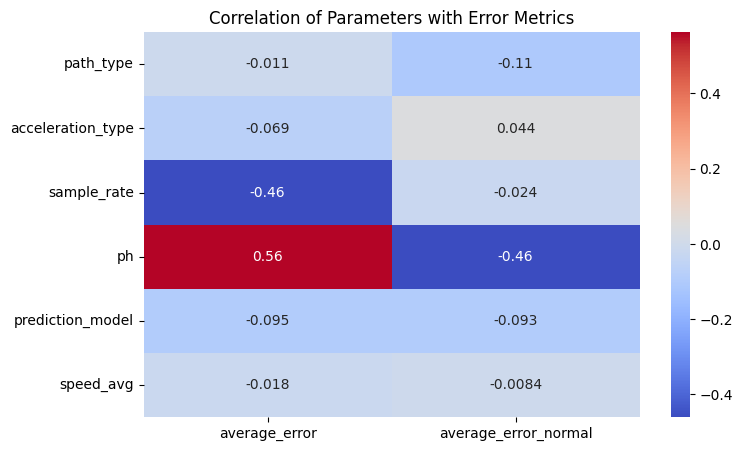

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.heatmap(target_corr, annot=True, cmap='coolwarm')
plt.title("Correlation of Parameters with Error Metrics")
plt.show()


In [13]:
results_df_filtered = pd.read_csv("results_df_both_110425_1.csv")

results_df_filtered_1 = results_df[
    (results_df['sample_rate'].isin(['10hz'])) &
    (results_df['ph'] == 4)
    # (results_df['dataset_name'] == 'CP_C_F_CCW_2') &
    # (results_df['acceleration_type'] == 'F') &
    # (results_df['speed_avg'] == False) &
    # (results_df['path_type'] == 'CP_C')
    ]

results_df_filtered_2 = results_df[
    (results_df['sample_rate'].isin(['2.5hz'])) &
    (results_df['ph'] == 1)
    # (results_df['dataset_name'] == 'CP_C_F_CCW_2') &
    # (results_df['acceleration_type'] == 'F') &
    # (results_df['speed_avg'] == False) &
    # (results_df['path_type'] == 'CP_C')
    ]

results_df_filtered = pd.concat([results_df_filtered_1, results_df_filtered_2]).drop_duplicates(keep='last').reset_index(drop=True)

# Copy and encode again if you didn't keep df_encoded
df_encoded = results_df_filtered.copy()

# Convert categorical columns to numeric codes
categorical_columns = ['acceleration_type', 'sample_rate', 'path_type', 'speed_avg']

for col in categorical_columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# Also encode 'prediction_model' to filter more easily
df_encoded['prediction_model'] = df_encoded['prediction_model'].astype(str)

# Filter for each model
ctrv_df = df_encoded[df_encoded['prediction_model'] == 'CTRV']
cv_df = df_encoded[df_encoded['prediction_model'] == 'CV']

# List of parameters to correlate
features = ['acceleration_type', 'sample_rate', 'ph', 'speed_avg', 'path_type']

# Compute correlations
ctrv_corr = ctrv_df[features + ['average_error']].corr().loc[features, 'average_error']
cv_corr = cv_df[features + ['average_error']].corr().loc[features, 'average_error']

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'CTRV': ctrv_corr,
    'CV': cv_corr
}).sort_values(by='CTRV', ascending=False)

print("Parameter correlation with average_error (CTRV vs CV):")
print(comparison_df)


Parameter correlation with average_error (CTRV vs CV):
                       CTRV        CV
ph                 0.790071  0.439846
speed_avg         -0.006156 -0.077863
path_type         -0.027075 -0.094048
acceleration_type -0.192018 -0.221626
sample_rate       -0.790071 -0.439846


In [14]:
results_df_filtered

,dataset_name,path_type,acceleration_type,path_direction,path_number,sample_rate,ph,prediction_model,speed_avg,average_error,average_error_normal
0,VL_C_F_TD_3,VL_C,F,TD,3,10hz,4,CTRV,True,47.433428,1.128212
1,VL_C_F_BU_5,VL_C,F,BU,5,10hz,4,CTRV,True,54.269216,0.997706
2,VL_C_F_BU_6,VL_C,F,BU,6,10hz,4,CTRV,True,37.044823,0.711153
3,VL_C_F_TD_5,VL_C,F,TD,5,10hz,4,CTRV,True,67.283725,1.266971
4,VL_C_A_TD_1,VL_C,A,TD,1,10hz,4,CTRV,True,61.414309,1.077279
...,...,...,...,...,...,...,...,...,...,...,...
819,CP_C_A_CW_3,CP_C,A,CW,3,2.5hz,1,CV,True,40.842084,0.822158
820,CP_C_A_CCW_2,CP_C,A,CCW,2,2.5hz,1,CV,True,43.384455,0.824830
821,CP_C_F_CCW_2,CP_C,F,CCW,2,2.5hz,1,CV,True,26.948742,0.865675
822,CP_C_F_CCW_3,CP_C,F,CCW,3,2.5hz,1,CV,True,41.401673,0.859915


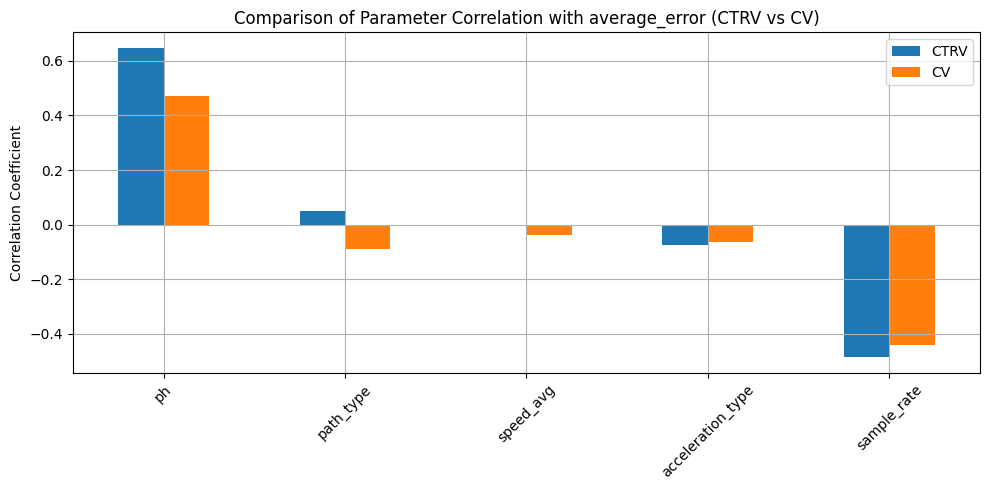

In [170]:
comparison_df.plot(kind='bar', figsize=(10, 5))
plt.title('Comparison of Parameter Correlation with average_error (CTRV vs CV)')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
